# Figure 1

Still a draft.

In [10]:
%matplotlib inline

import matplotlib.pyplot as plt
import matplotlib.path as mpath
import xarray as xr
import numpy as np
import cmocean as cm
import cartopy.crs as ccrs
import cartopy.feature as cft

In [3]:
HardDisk = '/g/data/v45/amh157/OCCIPUT/'
EnsembleDir = 'geouv/'

In [13]:
land_50m = cft.NaturalEarthFeature('physical', 'land', '50m',
                                        edgecolor='black',
                                        facecolor='gray',
                                        linewidth=1.0)

## Load a snapshot

In [54]:
ufilename = HardDisk+EnsembleDir+'e001/ugeo_001_1998.nc'
vfilename = HardDisk+EnsembleDir+'e001/vgeo_001_1998.nc'
gridfilename = HardDisk+'ORCA025.L75-MJM101.1_mesh_hgr.nc'
uds = xr.open_dataset(ufilename)
vds = xr.open_dataset(vfilename)
gridds = xr.open_dataset(gridfilename)

u=uds.vozocrtx.values
u2 = np.empty([73,1021,1442])
u2[:,1:,:] = 0.5*(u[:,:-1,:]+u[:,1:,:])
u2[:,0,:] = u[:,0,:]
u2 = u2*u2
    
v=vds.vomecrty.values
v2 = np.empty([73,1021,1442])
v2[:,:,1:] = 0.5*(v[:,:,:-1]+v[:,:,1:])
v2[:,:,0] = 0.5*(v[:,:,-1]+v[:,:,0])
v2 = v2*v2

eke = 0.5*(u2+v2)

lon = gridds.nav_lon.isel(y=0).values.copy()
lon[:430] = lon[:430]-360
lat = gridds.nav_lat.isel(x=387).values

ekeda  = xr.DataArray(eke[40,:-1,1:], coords=[('lat', lat[:-1]),
                                            ('lon', lon[1:])], name='EKE').fillna(0)

## Load EKE climatology

In [55]:
climfilename = HardDisk+EnsembleDir+'eke_climatology.nc'
eke_month = xr.open_dataset(climfilename).EKE.mean('month').fillna(0)

## Plot

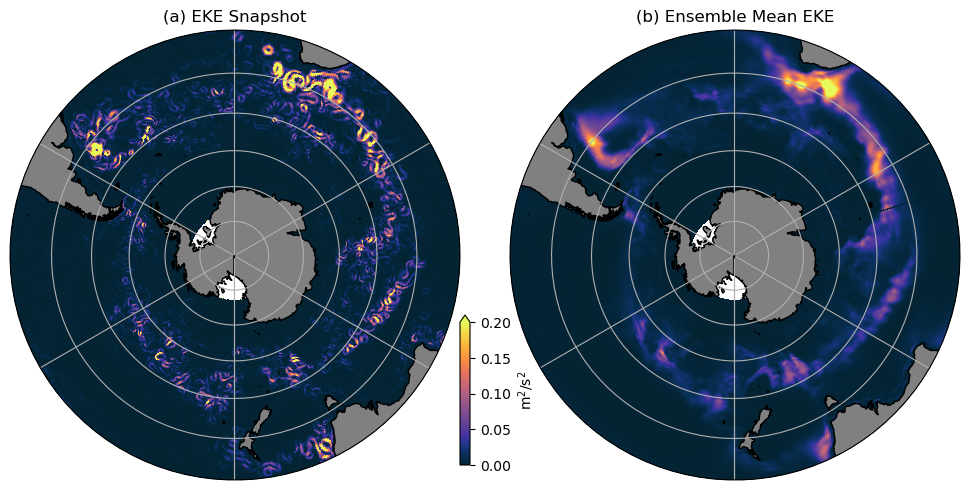

In [65]:
plt.figure(figsize=(10,5))

ax1 = plt.axes([0.02, 0.02, 0.45, 0.9],projection=ccrs.SouthPolarStereo())
ax1.set_extent([-287, 73, -80, -30], crs=ccrs.PlateCarree())
# Compute a circle in axes coordinates, which we can use as a boundary
# for the map. We can pan/zoom as much as we like - the boundary will be
# permanently circular
theta = np.linspace(0, 2*np.pi, 100)
center, radius = [0.5, 0.5], 0.5
verts = np.vstack([np.sin(theta), np.cos(theta)]).T
circle = mpath.Path(verts * radius + center)
ax1.set_boundary(circle, transform=ax1.transAxes)
ax1.add_feature(land_50m)
ax1.gridlines()
ekeda.plot(ax=ax1,vmax=0.2,cmap=cm.cm.thermal,add_colorbar=False,transform=ccrs.PlateCarree())
ax1.set_title('(a) EKE Snapshot')

ax2 = plt.axes([0.52, 0.02, 0.45, 0.9],projection=ccrs.SouthPolarStereo())
ax2.set_extent([-287, 73, -80, -30], crs=ccrs.PlateCarree())
ax2.set_boundary(circle, transform=ax2.transAxes)
ax2.add_feature(land_50m)
ax2.gridlines()
p1 = eke_month.plot(ax=ax2,cmap=cm.cm.thermal,vmax=0.2,add_colorbar=False,transform=ccrs.PlateCarree())
ax2.set_title('(b) Ensemble Mean EKE')

# Add colorbar
ax_col = plt.axes([0.47,0.05,0.01,0.3])
plt.colorbar(p1,cax=ax_col,orientation='vertical',extend='max')
ax_col.set_ylabel('m$^2$/s$^2$')

plt.savefig('../paper/figures/Figure1.png',dpi=200)